# Housing statistics
In this notebook we have a look at the dataset with housing statistics, found on Kaggle. We try to identify  correlations between various aspects and the sale price. 

In [2]:
# Start by importing required libraries
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [18]:
# Define used functions

def fit_ols(df, dep):
    """Fit OLS linear regression and return model and df."""
    
    df = sm.add_constant(df)
    cols = list(df.columns)
    cols.remove(dep)
    return sm.OLS(df[dep], df[cols]).fit(), df

def check_cor(df, r):
    """Return column if correlation above r."""
    
    return (df.corr()["SalePrice"][1:-1]
              .apply(lambda x: (x if abs(x) >= r else pd.NA))
              .dropna())

def plot_reg(model, df, x, y, ticks=None):
    """Plot scatter and regression line for model."""
    
    # If ticks is not provided we just use x
    if not isinstance(ticks, list):
        ticks = df[x]
        x = [x]
    
    plt.scatter(ticks, df[y], color = 'grey')
    plt.plot(ticks, model.predict(df[["const"] + x]))

In [4]:
# Import csv 
h = pd.read_csv(os.path.join("..", "data", "train.csv"))

# Ensure we view the entire set when showing dataset
pd.set_option('display.max_rows', h.shape[0]+1)

# First look at dataset
h.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Check what data types the columns are
h.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [6]:
# How many null-values per column?
h.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [7]:
# Get rid of columns that have a lot of missing data
h = h.dropna(axis=1, thresh=250)
h.shape

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


## A look at the data
Now we have cleaned the dataset a little, we can start exploring the data. 
* Saleprice over time
* Number of builds over time
* Find high correlation coefficients for columns
* Effect of 'Overall Quality'
* Effect of ground living area
* Effect of total surface area
* Effect of Neighborhood

Overal mean sale price: 180921


YrSold
2006    182549
2007    186063
2008    177360
2009    179432
2010    177393
Name: SalePrice, dtype: int32

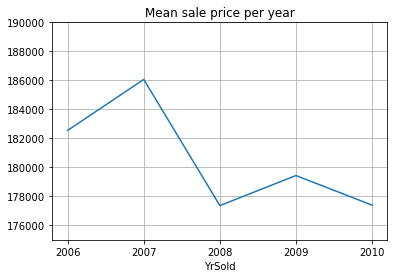

In [85]:
# Average sale price over time
print(f"Overal mean sale price: {int(h['SalePrice'].mean())}")
sp_y = h.groupby("YrSold")["SalePrice"].mean().astype(int)
sp_y.plot(xticks=range(2006,2011), 
          ylim=(175000, 190000), 
          grid=True,
          title="Mean sale price per year")
sp_y

NridgHt    13
NoRidge     8
StoneBr     4
OldTown     1
Somerst     1
CollgCr     1
Name: Neighborhood, dtype: int64

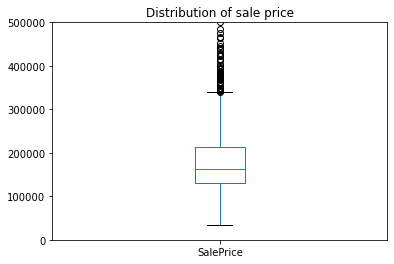

In [84]:
# How is the sale price distributed?
h["SalePrice"].plot(kind="box", ylim=(0, 500000), 
                    title="Distribution of sale price")
h[h["SalePrice"] > 400000]["Neighborhood"].value_counts()

In [110]:
# Check which columns won't be very interesting due low variance
[col
 for col in 
 [x for x in h.columns 
  if h[x].dtype in ["float64", "int64"]] 
 if h[col].min() == np.percentile(h[col], 90)]

['LowQualFinSF',
 'BsmtHalfBath',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

''

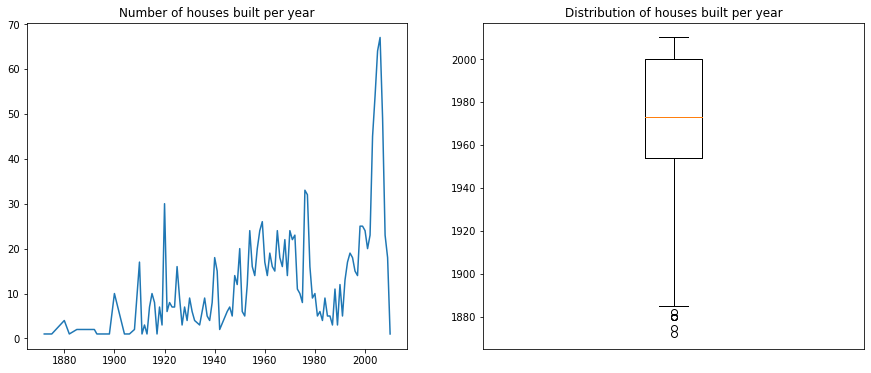

In [102]:
# Show graphs of build year
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(h["YearBuilt"].value_counts(sort=False))
ax[0].set_title("Number of houses built per year")
ax[1].boxplot(h["YearBuilt"])
ax[1].set_title("Distribution of houses built per year")
ax[1].set_xticks([])
""

#### Correlation check
For the aspects for which we found a high correlation with sale price, we have a closer look. By using the Ordinary Least Squares model we fit a regression. 

In [10]:
# Check correlation for all numerical columns
num_corr = check_cor(h, 0.6)
num_corr

OverallQual    0.790982
TotalBsmtSF    0.613581
1stFlrSF       0.605852
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: object

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1471.
Date:                Sat, 12 Sep 2020   Prob (F-statistic):          4.52e-223
Time:                        20:49:21   Log-Likelihood:                -18035.
No. Observations:                1460   AIC:                         3.607e+04
Df Residuals:                    1458   BIC:                         3.608e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.857e+04   4480.755      4.144      0.000    9779.612    2.74e+04
GrLivArea    107.1304      2.794     38.348      0.000     101.650     112.610
==============================================================================
Omnibus:                      261.166   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3432.287
Skew:                           0.410   Prob(JB):                         0.00
Kurtosis:                      10.467   Cond. No.                     4.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

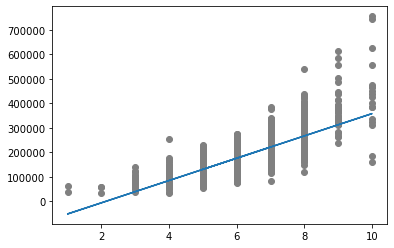

In [112]:
# Overall build quality
m, df = fit_ols(h[["OverallQual", "SalePrice"]], "SalePrice")
plot_reg(m, df, "OverallQual", "SalePrice")
liv_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1471.
Date:                Sat, 12 Sep 2020   Prob (F-statistic):          4.52e-223
Time:                        20:49:08   Log-Likelihood:                -18035.
No. Observations:                1460   AIC:                         3.607e+04
Df Residuals:                    1458   BIC:                         3.608e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.857e+04   4480.755      4.144      0.000    9779.612    2.74e+04
GrLivArea    107.1304      2.794     38.348      0.000     101.650     112.610
==============================================================================
Omnibus:                      261.166   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3432.287
Skew:                           0.410   Prob(JB):                         0.00
Kurtosis:                      10.467   Cond. No.                     4.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

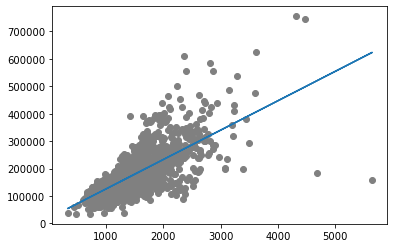

In [111]:
# Ground living area
m, df = fit_ols(h[["GrLivArea", "SalePrice"]], "SalePrice")
plot_reg(m, df, "GrLivArea", "SalePrice")
liv_model.summary()


In [12]:
# Total surface area
sf_col = ['TotalBsmtSF', '1stFlrSF', 
          '2ndFlrSF', 'GarageArea']
sf_df = h[sf_col + ["SalePrice"]]
m, df = fit_ols(sf_df, "SalePrice")

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     725.0
Date:                Sat, 12 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:53:16   Log-Likelihood:                -17744.
No. Observations:                1460   AIC:                         3.550e+04
Df Residuals:                    1455   BIC:                         3.552e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.276e+04   4229.525     -5.380      0.000   -3.11e+04   -1.45e+04
TotalBsmtSF    53.5713      4.870     10.999      0.000      44.018      63.125
1stFlrSF       63.7131      5.599     11.379      0.000      52.730      74.696
2ndFlrSF       72.0755      2.938     24.529      0.000      66.312      77.839
GarageArea    101.3675      6.838     14.824      0.000      87.954     114.781
==============================================================================
Omnibus:                      778.563   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            73351.494
Skew:                          -1.557   Prob(JB):                         0.00
Kurtosis:                      37.584   Cond. No.                     6.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Findings
There seems to be a strong correlation, especially between the total living area and the sale price.

## Neighborhood
It is also suspeced that the neighborhood is of influence to the sale price. 

Standard deviation: 79442

                mean     std         var
Neighborhood                            
NoRidge       335295  121412 -2147483648
NridgHt       316270   96392 -2147483648
StoneBr       310499  112969 -2147483648
Timber        242247   64845 -2147483648
Veenker       238772   72369 -2147483648
Somerst       225379   56177 -2147483648
ClearCr       212565   50231 -2147483648
Crawfor       210624   68866 -2147483648
CollgCr       197965   51403 -2147483648
Blmngtn       194870   30393   923748382
Gilbert       192854   35986  1295048268
NWAmes        189050   37172  1381773798
SawyerW       186555   55651 -2147483648
Mitchel       156270   36486  1331273828
NAmes         145847   33075  1093978476
NPkVill       142694    9377    87934027
SWISU         142591   32622  1064254757
Blueste       137500   19091   364500000
Sawyer        136793   22345   499304797
OldTown       128225   52650 -2147483648
Edwards       128219   43208  1866984536
BrkSide       124834   40348  

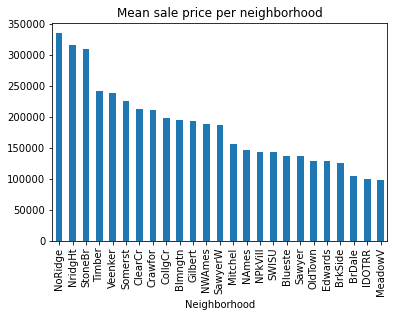

In [94]:
# Isolate the data
zone_price = (h.groupby("Neighborhood")["SalePrice"]
               .agg(["mean", "std", "var"])
               .sort_values(by="mean", ascending=False)
               .astype(int))

# Show the mean sale price per neighborhood in a graph
zone_price["mean"].plot(kind="bar", 
                        title="Mean sale price per neighborhood")
v = (h[["Neighborhood", "SalePrice"]]
     .std()[0]
     .astype(int))

print(f"Standard deviation: {v}\n")
print(zone_price)

In [16]:
# To have a closer look we assign dummy columns
zone = h[["Neighborhood", "SalePrice"]]
zone = pd.get_dummies(zone, drop_first=True, prefix="n")

# Check regression for neighborhood
m, df = fit_ols(zone, "SalePrice")
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     71.78
Date:                Sat, 12 Sep 2020   Prob (F-statistic):          1.56e-225
Time:                        17:53:54   Log-Likelihood:                -17968.
No. Observations:                1460   AIC:                         3.599e+04
Df Residuals:                    1435   BIC:                         3.612e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.949e+05   1.31e+04     14.879      0.000    1.69e+05    2.21e+05
n_Blueste  -5.737e+04   4.04e+04     -1.421      0.155   -1.37e+05    2.18e+04
n_BrDale   -9.038e+04   1.88e+04     -4.805      0.000   -1.27e+05   -5.35e+04
n_BrkSide  -7.004e+04   1.49e+04     -4.703      0.000   -9.93e+04   -4.08e+04
n_ClearCr   1.769e+04   1.66e+04      1.066      0.287   -1.49e+04    5.03e+04
n_CollgCr   3094.8910   1.38e+04      0.224      0.823    -2.4e+04    3.02e+04
n_Crawfor   1.575e+04   1.51e+04      1.042      0.298   -1.39e+04    4.54e+04
n_Edwards  -6.665e+04   1.42e+04     -4.705      0.000   -9.44e+04   -3.89e+04
n_Gilbert  -2016.3760   1.44e+04     -0.140      0.889   -3.03e+04    2.63e+04
n_IDOTRR   -9.475e+04   1.58e+04     -5.988      0.000   -1.26e+05   -6.37e+04
n_MeadowV  -9.629e+04   1.85e+04     -5.199      0.000   -1.33e+05      -6e+04
n_Mitchel   -3.86e+04   1.52e+04     -2.540      0.011   -6.84e+04   -8784.735
n_NAmes    -4.902e+04   1.36e+04     -3.609      0.000   -7.57e+04   -2.24e+04
n_NPkVill  -5.218e+04   2.23e+04     -2.344      0.019   -9.58e+04   -8510.657
n_NWAmes   -5820.8139   1.45e+04     -0.400      0.689   -3.43e+04    2.27e+04
n_NoRidge   1.404e+05   1.56e+04      9.015      0.000     1.1e+05    1.71e+05
n_NridgHt   1.214e+05   1.45e+04      8.390      0.000     9.3e+04     1.5e+05
n_OldTown  -6.665e+04    1.4e+04     -4.744      0.000   -9.42e+04   -3.91e+04
n_SWISU    -5.228e+04    1.7e+04     -3.080      0.002   -8.56e+04    -1.9e+04
n_Sawyer   -5.808e+04   1.45e+04     -3.999      0.000   -8.66e+04   -2.96e+04
n_SawyerW  -8315.0857   1.49e+04     -0.559      0.576   -3.75e+04    2.08e+04
n_Somerst   3.051e+04   1.43e+04      2.129      0.033    2393.494    5.86e+04
n_StoneBr   1.156e+05    1.7e+04      6.812      0.000    8.23e+04    1.49e+05
n_Timber    4.738e+04   1.58e+04      3.007      0.003    1.65e+04    7.83e+04
n_Veenker    4.39e+04   2.09e+04      2.101      0.036    2913.679    8.49e+04
==============================================================================
Omnibus:                      618.883   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5526.438
Skew:                           1.737   Prob(JB):                         0.00
Kurtosis:                      11.875   Cond. No.                         48.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
col_drop = [col for col in h.columns if col not in ["YearBuilt", "SalePrice"]]

y_sp = (h.copy()
         .drop(columns=col_drop)
         .groupby(by="YearBuilt")
         .agg("mean")
         .astype(int).sort_values(by="YearBuilt")
         .reset_index())
y_sp = (y_sp.assign({"t": y_sp.index + 1,
                     "t2": (y_sp.index +1) ** 2}))

NameError: name 'y_sp' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df_weekly["week_id"],
        df_weekly["pageviews"],
        color="black");

ax.plot(df_weekly["week_id"],
        df_weekly["pred_pageviews"],
        color="cornflowerblue");

ax.plot(df_weekly["week_id"],
        df_weekly["pred_pageviews2"],
        color="navy");